# About
This notebook is the 2nd place solution, which is a slightly modified version.　In this notebook, I predict FVC with EfficientNets B3 and Quantile Regression. The final submission score is as follows.

Private Score: -6.8311
Public  Score: -6.8866

# Setting

In [1]:
!pip install ../input/kerasapplications/keras-team-keras-applications-3b180cb -f ./ --no-index
!pip install ../input/efficientnet/efficientnet-1.1.0/ -f ./ --no-index

Looking in links: ./
Processing /kaggle/input/kerasapplications/keras-team-keras-applications-3b180cb
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=50704 sha256=3c03b24bc1311a0d0cecee2275db3ee36937ed2945b6b80e5133295268dc21dd
  Stored in directory: /root/.cache/pip/wheels/f4/96/13/eccdd9391bd8df958d78851b98ec4dc207ba05b67b011eb70a
Successfully built Keras-Applications
Looking in links: ./
Processing /kaggle/input/efficientnet/efficientnet-1.1.0
  Created wheel for efficientnet: filename=efficientnet-1.1.0-py3-none-any.whl size=14141 sha256=1ca432a18d638d1df341ef61e73bd547c63fb79ff8b0cbb54f03088cb715683d
  Stored in directory: /root/.cache/pip/wheels/24/f5/31/3cc20871288fe532128224a3f5af7b4d67efb9835bd5683522
Successfully built efficientnet


In [2]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import random

import cv2
import pydicom

from tqdm.notebook import tqdm
from plotnine import *
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import (
    Dense, Dropout, Activation, Flatten, Input, BatchNormalization, GlobalAveragePooling2D, Add, Conv2D, AveragePooling2D, 
    LeakyReLU, Concatenate 
)
import efficientnet.tfkeras as efn

from tensorflow.keras import Model
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

import json
import gc

In [3]:
# Setting Seeds
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    
seed_everything(42)

In [4]:
# Setting TensorFlow
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [5]:
# Load Setting File
json_open = open('../input/settings/settings.json')
SETTINGS = json.load(json_open)

PATH = SETTINGS['PATH']
PARAMS = SETTINGS['PARAMS']
FEATURES = SETTINGS['FEATURES']

print(SETTINGS)

{'PATH': {'ROOT': '../input/', 'TRAIN_CSV_PATH': '../input/osic-pulmonary-fibrosis-progression/train.csv', 'TEST_CSV_PATH': '../input/osic-pulmonary-fibrosis-progression/test.csv', 'SAMPLESUB_CSV_PATH': '../input/osic-pulmonary-fibrosis-progression/sample_submission.csv', 'TRAIN_DATA_DIR': '../input/osic-pulmonary-fibrosis-progression/train/', 'TEST_DATA_DIR': '../input/osic-pulmonary-fibrosis-progression/test/', 'MASK_NOISE_DIR': '../input/osic-pulmonary-fibrosis-progression-lungs-mask/mask_noise/mask_noise/', 'TRAIN_MODEL_WEIGHTS_DIR': '../input/training-osic-2nd-place-code/'}, 'PARAMS': {'MODELS_EFF': [0], 'WEIGHT_EFF': 0.2, 'NFOLDS': 4, 'BATCH_SIZE': 128, 'EPOCHS': 300, 'EARLY_STOPPING': 150, 'NUM_LAST_FVC': 2, 'QS1': 0.2, 'QS2': 0.5, 'QS3': 0.8}, 'PARAMS_TRAIN_EFF': {'EPOCHS': 50, 'BATCH_SIZE': 8, 'NFOLDS': 5, 'LR': 0.003, 'MODEL_CLASS': 'b3'}, 'FEATURES': ['Sex_Female', 'Sex_Male', 'SmokingStatus_Currently smokes', 'SmokingStatus_Ex-smoker', 'SmokingStatus_Never smoked', 'age', '

# EfficientNet-B3
## Preprocess
### Feature Engineering

In [6]:
# Load Train Data
train = pd.read_csv(PATH["TRAIN_CSV_PATH"]) 


# Get Tabular Data
def get_tab(df):
    vector = [(df.Age.values[0] - 30) / 30] 
    
    if df.Sex.values[0] == 'male':
       vector.append(0)
    else:
       vector.append(1)
    
    if df.SmokingStatus.values[0] == 'Never smoked':
        vector.extend([0,0])
    elif df.SmokingStatus.values[0] == 'Ex-smoker':
        vector.extend([1,1])
    elif df.SmokingStatus.values[0] == 'Currently smokes':
        vector.extend([0,1])
    else:
        vector.extend([1,0])
    return np.array(vector) 


A = {} 
TAB = {} 
P = [] 
for i, p in tqdm(enumerate(train['Patient'].unique())):
    sub = train.loc[train['Patient'] == p, :] 
    fvc = sub['FVC'].values
    weeks = sub['Weeks'].values
    c = np.vstack([weeks, np.ones(len(weeks))]).T
    a, b = np.linalg.lstsq(c, fvc)[0]
    
    A[p] = a
    TAB[p] = get_tab(sub)
    P.append(p)

## Inference
### Define Model

In [7]:
# Metric
def score(fvc_true, fvc_pred, sigma):
    sigma_clip = np.maximum(sigma, 70)
    delta = np.abs(fvc_true - fvc_pred)
    delta = np.minimum(delta, 1000)
    sq2 = np.sqrt(2)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)


# Get Image Data
def get_img(path):
    d = pydicom.dcmread(path)
    return cv2.resize(d.pixel_array / 2**11, (512, 512))


# Load Data
class IGenerator(Sequence):
    BAD_ID = ['ID00011637202177653955184', 'ID00052637202186188008618']
    def __init__(self, keys, a, tab, batch_size=32):
        self.keys = [k for k in keys if k not in self.BAD_ID]
        self.a = a
        self.tab = tab
        self.batch_size = batch_size
        
        self.train_data = {}
        for p in train['Patient'].values:
            self.train_data[p] = os.listdir(f'{PATH["TRAIN_DATA_DIR"]}{p}/')
    
    def __len__(self):
        return 1000
    
    def __getitem__(self, idx):
        x = []
        a, tab = [], [] 
        keys = np.random.choice(self.keys, size = self.batch_size)
        for k in keys:
            try:
                i = np.random.choice(self.train_data[k], size=1)[0]
                img = get_img(f'{PATH["TRAIN_DATA_DIR"]}{k}/{i}')
                x.append(img)
                a.append(self.a[k])
                tab.append(self.tab[k])
            except:
                print(k, i)
       
        x,a,tab = np.array(x), np.array(a), np.array(tab)
        x = np.expand_dims(x, axis=-1)
        return [x, tab] , a

In [8]:
# Make Model
def get_efficientnet(model, shape):
    models_dict = {
        'b0': efn.EfficientNetB0(input_shape=shape,weights=None,include_top=False),
        'b1': efn.EfficientNetB1(input_shape=shape,weights=None,include_top=False),
        'b2': efn.EfficientNetB2(input_shape=shape,weights=None,include_top=False),
        'b3': efn.EfficientNetB3(input_shape=shape,weights=None,include_top=False),
        'b4': efn.EfficientNetB4(input_shape=shape,weights=None,include_top=False),
        'b5': efn.EfficientNetB5(input_shape=shape,weights=None,include_top=False),
        'b6': efn.EfficientNetB6(input_shape=shape,weights=None,include_top=False),
        'b7': efn.EfficientNetB7(input_shape=shape,weights=None,include_top=False)
    }
    return models_dict[model]


def build_model(shape=(512, 512, 1), model_class=None, fold=0):
    inp = Input(shape=shape)
    base = get_efficientnet(model_class, shape)
    x = base(inp)
    x = GlobalAveragePooling2D()(x)
    inp2 = Input(shape=(4,))
    x2 = tf.keras.layers.GaussianNoise(0.2)(inp2)
    x = Concatenate()([x, x2]) 
    x = Dropout(0.5)(x) 
    x = Dense(1)(x)
    model = Model([inp, inp2] , x)
    
    weights = "fold-" + str(fold) + ".h5"
    model.load_weights(PATH["TRAIN_MODEL_WEIGHTS_DIR"] + weights)
    return model


models = [build_model(shape=(512, 512, 1), model_class='b3', fold=i) for i in PARAMS['MODELS_EFF']]
print('Number of models: ' + str(len(models)))

Number of models: 1


### Predict

In [9]:
# Predict with Each Fold
tr_p, vl_p = train_test_split(P, shuffle=True, train_size = 0.8) 
subs = []
for model in models:
    metric = []
    for q in tqdm(range(1, 10)):
        m = []
        for p in vl_p:
            x = [] 
            tab = [] 

            if p in ['ID00011637202177653955184', 'ID00052637202186188008618']:
                continue

            ldir = os.listdir(f'{PATH["TRAIN_DATA_DIR"]}{p}/')
            for i in ldir:
                if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                    x.append(get_img(f'{PATH["TRAIN_DATA_DIR"]}{p}/{i}')) 
                    tab.append(get_tab(train.loc[train.Patient == p, :])) 
            if len(x) < 1:
                continue
            tab = np.array(tab) 

            x = np.expand_dims(x, axis=-1) 
            _a = model.predict([x, tab]) 
            a = np.quantile(_a, q / 10)

            percent_true = train.Percent.values[train.Patient == p]
            fvc_true = train.FVC.values[train.Patient == p]
            weeks_true = train.Weeks.values[train.Patient == p]

            fvc = a * (weeks_true - weeks_true[0]) + fvc_true[0]
            percent = percent_true[0] - a * abs(weeks_true - weeks_true[0])
            m.append(score(fvc_true, fvc, percent))
        print(np.mean(m))
        metric.append(np.mean(m))

    q = (np.argmin(metric) + 1)/ 10

    sub = pd.read_csv(PATH["SAMPLESUB_CSV_PATH"]) 
    test = pd.read_csv(PATH["TEST_CSV_PATH"]) 
    A_test, B_test, P_test,W, FVC= {}, {}, {},{},{} 
    STD, WEEK = {}, {} 
    for p in test.Patient.unique():
        x = [] 
        tab = [] 
        ldir = os.listdir(f'{PATH["TEST_DATA_DIR"]}{p}/')
        for i in ldir:
            if int(i[:-4]) / len(ldir) < 0.8 and int(i[:-4]) / len(ldir) > 0.15:
                x.append(get_img(f'{PATH["TEST_DATA_DIR"]}{p}/{i}')) 
                tab.append(get_tab(test.loc[test.Patient == p, :])) 
        if len(x) <= 1:
            continue
        tab = np.array(tab) 

        x = np.expand_dims(x, axis=-1) 
        _a = model.predict([x, tab]) 
        a = np.quantile(_a, q)
        A_test[p] = a
        B_test[p] = test.FVC.values[test.Patient == p] - a*test.Weeks.values[test.Patient == p]
        P_test[p] = test.Percent.values[test.Patient == p] 
        WEEK[p] = test.Weeks.values[test.Patient == p]

    for k in sub.Patient_Week.values:
        p, w = k.split('_')
        w = int(w) 

        fvc = A_test[p] * w + B_test[p]
        sub.loc[sub.Patient_Week == k, 'FVC'] = fvc
        sub.loc[sub.Patient_Week == k, 'Confidence'] = (
            P_test[p] - A_test[p] * abs(WEEK[p] - w) 
    ) 

    _sub = sub[["Patient_Week","FVC","Confidence"]].copy()
    subs.append(_sub)

6.743880627526683
6.743880431141242
6.7438812867561815
6.743882403913062
6.743883844602182
6.743886296749025
6.743888407940562
6.74388824565989
6.743902975790736



## Make Submission

In [10]:
N = len(subs)
sub_eff = subs[0].copy() # ref
sub_eff["FVC"] = 0
sub_eff["Confidence"] = 0
for i in range(N):
    sub_eff["FVC"] += subs[0]["FVC"] * (1/N)
    sub_eff["Confidence"] += subs[0]["Confidence"] * (1/N)
    
sub_eff = sub_eff.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
sub_eff.to_csv('submission_eff.csv', index=False)
print(sub_eff.head())

                    Patient_Week          FVC  Confidence
0   ID00419637202311204720264_-1  3047.519632   97.706487
1  ID00419637202311204720264_-10  3082.902016  133.088871
2  ID00419637202311204720264_-11  3086.833392  137.020247
3  ID00419637202311204720264_-12  3090.764768  140.951623
4   ID00419637202311204720264_-2  3051.451008  101.637863


# Quantile Regression
## Preprocessing
### Feature Engineering

In [11]:
# Load Train Data
train_df = pd.read_csv(PATH['TRAIN_CSV_PATH'])
train_df.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])

# Load Test Data
test_df = pd.read_csv(PATH['TEST_CSV_PATH'])
sub_df = pd.read_csv(PATH['SAMPLESUB_CSV_PATH'], usecols = ['Patient_Week', 'Confidence'])
sub_df[['Patient', 'Weeks']] = sub_df['Patient_Week'].apply(lambda x: pd.Series([x.split('_')[0], int(x.split('_')[-1])]))
sub_df = sub_df.merge(test_df.drop('Weeks', axis=1), on='Patient')

train_df['data'] = 'train'
test_df['data'] = 'test'
sub_df['data'] = 'sub'

# Recalculate 'Weeks'
data = train_df.append([test_df, sub_df])
data['min_week'] = data['Weeks']
data.loc[data['data'] == 'sub', 'min_week'] = np.nan
data['min_week'] = data.groupby('Patient')['min_week'].transform('min')
data['base_week'] = data['Weeks'] - data['min_week']

# Fix 'Percent' and 'FVC' to the initial values
data_init = data.loc[data['Weeks'] == data['min_week']][['Patient', 'FVC', 'Percent']]
data_init.columns = ['Patient', 'min_FVC', 'min_Percent']
data_init['nb'] = 1
data_init['nb'] = data_init.groupby('Patient')['nb'].transform('cumsum')
data_init = data_init[data_init.nb==1]
data = data.merge(data_init, on='Patient', how='left')

del test_df, data_init
gc.collect()

# One-Hot Encoding ('Sex', 'SmokingStatus')
FE_CATEGORICAL = ['Sex', 'SmokingStatus']
data_categorical = pd.get_dummies(data[FE_CATEGORICAL])
data = pd.concat([data, data_categorical], axis=1)

del data_categorical
gc.collect()

# Min-Max Scaler ('Age', 'FVC', 'Weeks', 'Percent')
data['age'] = (data['Age'] - data['Age'].min()) / (data['Age'].max() - data['Age'].min())
data['min_fvc'] = (data['min_FVC'] - data['min_FVC'].min()) / (data['min_FVC'].max() - data['min_FVC'].min())
data['week'] = (data['base_week'] - data['base_week'].min()) / (data['base_week'].max() - data['base_week'].min())
data['percent'] = (data['min_Percent'] - data['min_Percent'].min()) / (data['min_Percent'].max() - data['min_Percent'].min())

# Split Data
train_df = data.loc[data['data'] == 'train']
sub_df = data.loc[data['data'] == 'sub']

### Cluster Patients


In [12]:
# Linear Regression with the last few FVC
training_patient = train_df[~train_df.duplicated(subset=['Patient'])]

for patient in tqdm(train_df['Patient'].unique()): 
    idx = train_df['Patient'] == patient
    z = ((train_df.loc[idx, 'FVC'].values[-PARAMS['NUM_LAST_FVC']:] - train_df.loc[idx, 'FVC'].values[-PARAMS['NUM_LAST_FVC']:].mean()) /
         train_df.loc[idx, 'FVC'].values[-PARAMS['NUM_LAST_FVC']:].std())
    reg = LinearRegression(normalize=True,fit_intercept=True).fit(train_df.loc[idx, 'Weeks'].values[-PARAMS['NUM_LAST_FVC']:].reshape(-1,1),z)
    train_df.loc[idx, 'Intercept_2'] = reg.intercept_
    train_df.loc[idx, 'Coef_2'] = reg.coef_[0]
    
training_patient = train_df.drop_duplicates('Patient') 
(ggplot(training_patient) + aes(x='Intercept_2',y='Coef_2',fill='Sex',size='FVC') + geom_point(alpha=0.4) )

# Clustering Patients
cust_array = np.array([training_patient['Intercept_2'].tolist(),training_patient['Coef_2'].tolist()])
cust_array = cust_array.T

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(cust_array)
training_patient['Group'] = clusters.labels_

(ggplot(training_patient) + aes(x='Intercept_2',y='Coef_2',fill='Group') + geom_point(alpha=0.4) )

skf = StratifiedKFold(n_splits=PARAMS['NFOLDS'])
splitter = skf.split(training_patient, training_patient['Group'])

## Training
### Define Model

In [13]:
# Metric
def score(y_true, y_pred):
    C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]

    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)


# Pinball Loss
def qloss(y_true, y_pred, qs1=PARAMS['QS1'], qs2=PARAMS['QS2'], qs3=PARAMS['QS3']):
    qs = [qs1, qs2, qs3]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)


# Loss
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss


# Build Model
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)

    p1 = L.Dense(3, activation="linear", name="p1")(x)
    p2 = L.Dense(3, activation="relu", name="p2")(x)
    preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])
    
    model = M.Model(z, preds, name="CNN")
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

### Train

FOLD 0
train loss:48.15951 score:6.61844
 val  loss:62.19877 score:6.92239


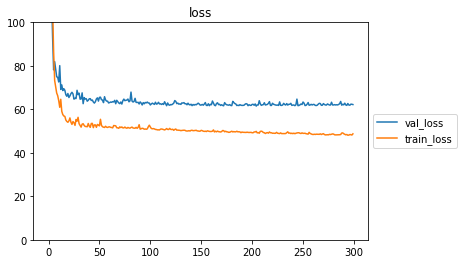

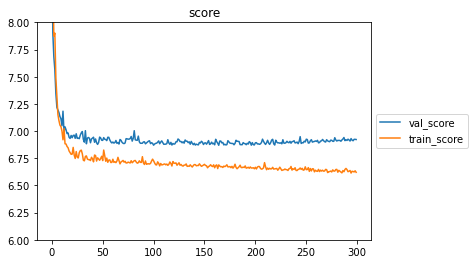

FOLD 1
train loss:46.47879 score:6.62071
 val  loss:82.29725 score:7.28509


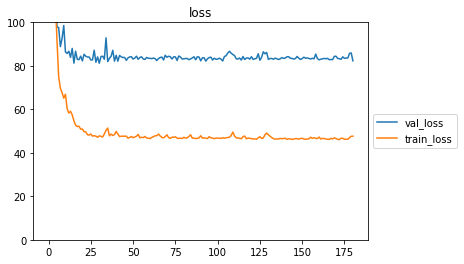

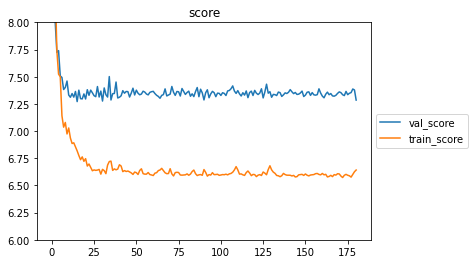

FOLD 2
train loss:50.86448 score:6.67315
 val  loss:63.14377 score:6.88676


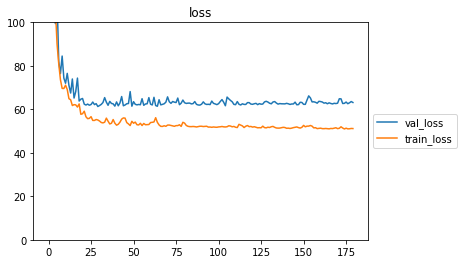

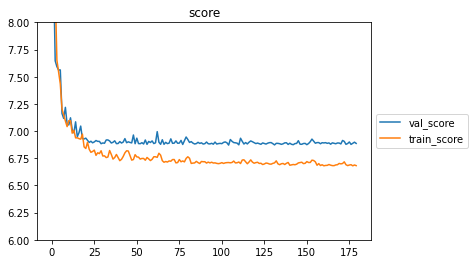

FOLD 3
train loss:51.74122 score:6.71283
 val  loss:65.04294 score:6.93638


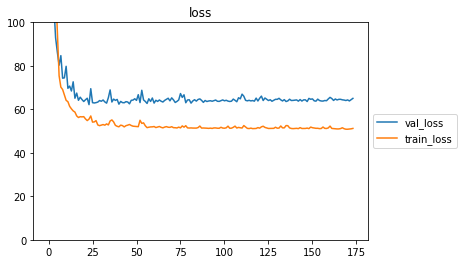

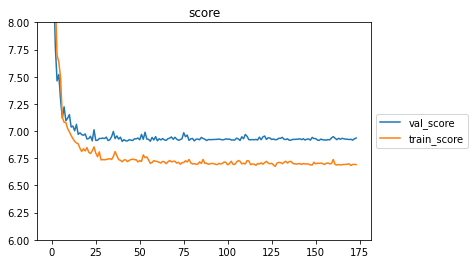

In [14]:
# Prepare for training
y = train_df['FVC'].values.astype('float32')
z_train = train_df[FEATURES].values
z_sub = sub_df[FEATURES].values
nh = z_train.shape[1]
pred_train = np.zeros((z_train.shape[0], 3))
pred_sub = np.zeros((z_sub.shape[0], 3))

# Cross-Validation
for cnt, (tr_idx_pati, val_idx_pati) in enumerate(splitter):
    # Preprocess
    patient_train = training_patient['Patient'].iloc[tr_idx_pati]
    patient_test = training_patient['Patient'].iloc[val_idx_pati]

    tr_idx = train_df['Patient'].isin(patient_train)
    val_idx = train_df['Patient'].isin(patient_test)
    
    data_train = train_df[tr_idx]
    data_val = train_df[val_idx]
    
    data_train = data_train.sort_values(['Patient', 'Weeks'], ascending=True)
    data_val = data_val.sort_values(['Patient', 'Weeks'], ascending=True)
    
    # Choose the last 3 FVC for validation
    tmp = pd.DataFrame(columns = data_val.columns)
    for i in range(3):
        keep_idx = data_val.duplicated(subset=['Patient'], keep='last')
        tmp = tmp.append(data_val[~keep_idx])
        data_val = data_val[keep_idx]
    data_val = tmp
    del tmp
    gc.collect()
                      
    tr_idx = data_train.index
    val_idx = data_val.index   
    
    # Train
    print(f'FOLD {cnt}')
    model = make_model(nh)
    modelCheckpoint = ModelCheckpoint(f'fold{cnt}.h5' , monitor='val_loss', verbose=0, save_best_only = True, save_weights_only=False, mode='auto')
    early_stopping = EarlyStopping(monitor='val_loss', patience=PARAMS['EARLY_STOPPING'], verbose=0, mode='auto')
    stack = model.fit(z_train[tr_idx], y[tr_idx], batch_size=PARAMS['EARLY_STOPPING'], 
                      validation_data=(z_train[val_idx], y[val_idx]), 
                      epochs=PARAMS['EPOCHS'],
                      callbacks=[modelCheckpoint, early_stopping],
                      verbose=0)
     
    # Predict
    pred_train[val_idx] = model.predict(z_train[val_idx], batch_size=PARAMS['EARLY_STOPPING'], verbose=0)
    pred_sub += model.predict(z_sub, batch_size=PARAMS['EARLY_STOPPING'], verbose=0) / PARAMS['NFOLDS']
    
    # Evaluate training
    train_loss, train_score = model.evaluate(z_train[tr_idx], y[tr_idx], verbose=0, batch_size=PARAMS['EARLY_STOPPING'])
    val_loss, val_score = model.evaluate(z_train[val_idx], y[val_idx], verbose=0, batch_size=PARAMS['EARLY_STOPPING'])
    
    # Print loss and score
    print(f'train loss:{train_loss:.5f} score:{train_score:.5f}')
    print(f' val  loss:{val_loss:.5f} score:{val_score:.5f}')

    # Plot loss
    fig=plt.figure()
    plt.plot(stack.history['val_loss'], label="val_loss")
    plt.plot(stack.history['loss'], label="train_loss")
    plt.ylim([0,100])
    plt.title("loss")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    plt.clf()
    plt.close()

    # Plot score
    fig=plt.figure()
    plt.plot(stack.history['val_score'], label="val_score")
    plt.plot(stack.history['score'], label="train_score")
    plt.ylim([6,8])
    plt.title("score")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

### Evaluate

In [15]:
# Calculate Cross-Validation Score
def cal_cv(y_true, y_pred):
    sigma = y_pred[:, 2] - y_pred[:, 0]
    fvc_pred = y_pred[:, 1]
    sigma_clip = np.max(sigma)
    delta = np.abs(y_true[:, 0] - fvc_pred)
    delta = np.min(delta)
    sq2 = np.sqrt(2.)
    metric = (delta / sigma_clip)*sq2 + np.log(sigma_clip* sq2)
    return np.mean(metric)


cv_score=0
for id_patient in train_df['Patient'].unique():
    idx_patient = train_df.loc[train_df['Patient'] == id_patient].index
    cv_score += cal_cv(np.array(y[idx_patient]).reshape(-1, 1), pred_train[idx_patient])
cv_score /= len(train_df['Patient'].unique())
print(f"CV score : {cv_score:.5f}")

CV score : 6.58772


## Make Submission

In [16]:
# Calculate Confidence
sigma_opt = mean_absolute_error(y, pred_train[:, 1])
unc = pred_train[:,2] - pred_train[:, 0]
sigma_mean = np.mean(unc)

sub_df['FVC1'] = pred_sub[:, 1]
sub_df['Confidence1'] = pred_sub[:, 2] - pred_sub[:, 0]
sub_reg = sub_df[['Patient_Week','FVC','Confidence','FVC1','Confidence1']].copy()

sub_reg.loc[~sub_reg['FVC1'].isnull(),'FVC'] = sub_reg.loc[~sub_reg['FVC1'].isnull(),'FVC1']
if sigma_mean<70:
    sub_reg['Confidence'] = sigma_opt
else:
    sub_reg.loc[~sub_reg['FVC1'].isnull(),'Confidence'] = sub_reg.loc[~sub_reg['FVC1'].isnull(),'Confidence1']

In [17]:
# Make CSV
otest = pd.read_csv(PATH["TEST_CSV_PATH"])
for i in range(len(otest)):
    sub_reg.loc[sub_reg['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'FVC'] = otest.FVC[i]
    sub_reg.loc[sub_reg['Patient_Week']==otest.Patient[i]+'_'+str(otest.Weeks[i]), 'Confidence'] = 0.1

sub_reg = sub_reg.sort_values(by=['Patient_Week'], ascending=True).reset_index(drop=True)
sub_reg = sub_reg[['Patient_Week', 'FVC', 'Confidence']]
sub_reg.to_csv('submission_reg.csv', index=False)
print(sub_reg.head())

                    Patient_Week          FVC  Confidence
0   ID00419637202311204720264_-1  2999.261841  278.657654
1  ID00419637202311204720264_-10  3024.713440  269.021240
2  ID00419637202311204720264_-11  3027.541504  267.950562
3  ID00419637202311204720264_-12  3030.369446  266.879883
4   ID00419637202311204720264_-2  3002.089722  277.586853


# Ensemble

In [18]:
# Simple Blending
subm = sub_reg[['Patient_Week']].copy()
subm['FVC'] = PARAMS['WEIGHT_EFF']*sub_eff['FVC'] + (1-PARAMS['WEIGHT_EFF'])*sub_reg['FVC']
subm['Confidence'] = PARAMS['WEIGHT_EFF']*sub_eff['Confidence'] + (1-PARAMS['WEIGHT_EFF'])*sub_reg['Confidence']
subm.to_csv('submission.csv', index=False)
print(subm.head())

                    Patient_Week          FVC  Confidence
0   ID00419637202311204720264_-1  3008.913399  242.467420
1  ID00419637202311204720264_-10  3036.351155  241.834766
2  ID00419637202311204720264_-11  3039.399881  241.764499
3  ID00419637202311204720264_-12  3042.448510  241.694231
4   ID00419637202311204720264_-2  3011.961979  242.397055
